In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Concatenate, Activation, BatchNormalization, Conv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform,HeUniform
import numpy as np
import matplotlib.pyplot as plt
from segmentation_models.metrics import iou_score
import cv2
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
import segmentation_models as sm
import os
from pycocotools.coco import COCO
from utils_dataset import Dataloder, ImageData4, visualize, get_training_augmentation, get_validation_augmentation
from canet_model import convolutional_block,identity_block,global_flow,context_flow,agcn,fsm

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
tf.keras.backend.set_image_data_format('channels_last')
sm.set_framework('tf.keras')

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(sm.__version__)

Segmentation Models: using `keras` framework.
2.8.0
1.22.2
4.5.5
1.0.1


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def get_vgg_16_backbone():
    tf.keras.backend.clear_session()
    vgg_16 = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None,
                                               input_shape=(512,512,3))
    block3_c1 = vgg_16.get_layer('block3_conv1').output
    backbone = Model(vgg_16.layers[0].input, block3_c1)
    return backbone

In [4]:
class vgg_backbone(tf.keras.layers.Layer):
    
    def __init__(self,name="backbone_block"):
        super().__init__()
        self.backbone = get_vgg_16_backbone()
    def call(self, X):
        X = self.backbone(X)
        return X
    
def create_cmodel():
    
    tf.keras.backend.clear_session()
    start_filters = np.array([4,4,8])
    n_classes = 1
    
    input = Input((512,512,3))
    m = vgg_backbone()(input)
    print(f'Backbone output shape : {m.shape}')
    m = tf.keras.layers.Conv2D(8, 1, 1, "same",kernel_initializer=HeUniform,activation=Activation('relu'))(m)

    c1 = m
    c =  convolutional_block(kernel=3,  filters=list(2*start_filters), stride=2,name='conv_block_c2')(m)
    c =  identity_block(kernel=3,  filters=list(2*start_filters),name='indentity_block_c2')(c)

    c =  convolutional_block(kernel=3,  filters=list(4*start_filters), stride=1,name='conv_block_c3')(c)
    c =  identity_block(kernel=3,  filters=list(4*start_filters),name='indentity_block_c3')(c)

    c =  convolutional_block(kernel=3,  filters=list(8*start_filters), stride=1,name='conv_block_c4')(c)
    c =  identity_block(kernel=3,  filters=list(8*start_filters),name='indentity_block_c4')(c)
    c4 = c 

    # Global Flow
    w,h,c = c4.shape[1:]
    gf = global_flow(w,h,do_upsample=True,channels=c)(c4)

    #Context flow 1
    channels = gf.shape[-1]

    cf1_in = [c4,gf]
    cf1 = context_flow(channels=channels,name='context_flow1')(cf1_in)

    #Context flow 2
    cf2_in = [c4,cf1]
    cf2 = context_flow(channels=channels,name='context_flow2')(cf2_in)

    #Context flow 3
    cf3_in = [c4,cf2]
    cf3 = context_flow(channels=channels,name='context_flow3')(cf3_in)

    # Add outputs of context flows & global_flow
    cf_add = Add()([gf,cf1,cf2,cf3])

    # Feature selection module
    fsm_out = fsm(channels=cf_add.shape[-1])(cf_add)
    agcn_out = agcn(channels=m.shape[-1])(c1)

    agcn_fsm_concat = Concatenate()([fsm_out, agcn_out])

    conv3x3_out = Conv2D(n_classes,
                    kernel_size=(3,3),
                    strides=(1,1),activation="relu",
                    padding="same",name='conv_out',
                    kernel_initializer=HeUniform)(agcn_fsm_concat)

    upsample = UpSampling2D(size=(4,4),interpolation='bilinear',name='upsampled_out')(conv3x3_out)

    upsample = BatchNormalization(axis=-1,name='BN_out')(upsample)
    conv3x3_output = Conv2D(n_classes,kernel_size=(3,3),strides=(1,1),padding='same', kernel_initializer=HeUniform,
                            name='conv3x3_output')(upsample)

    output = Activation("sigmoid",name='SigmoidOut')(conv3x3_output)

    mm_model = Model(inputs = input, outputs = output)
    
    # Make the backbone non-trainable
    i=0
    for l in mm_model.layers:
        if i == 0 or i==1:
            l.trainable = False
        else:
            pass
        i+=1
    
    return mm_model

In [5]:
mm_model = create_cmodel()
for i in mm_model.layers:
    if i.trainable == False:
        print(i)

Backbone output shape : (None, 128, 128, 256)


In [6]:
#mm_model.summary()

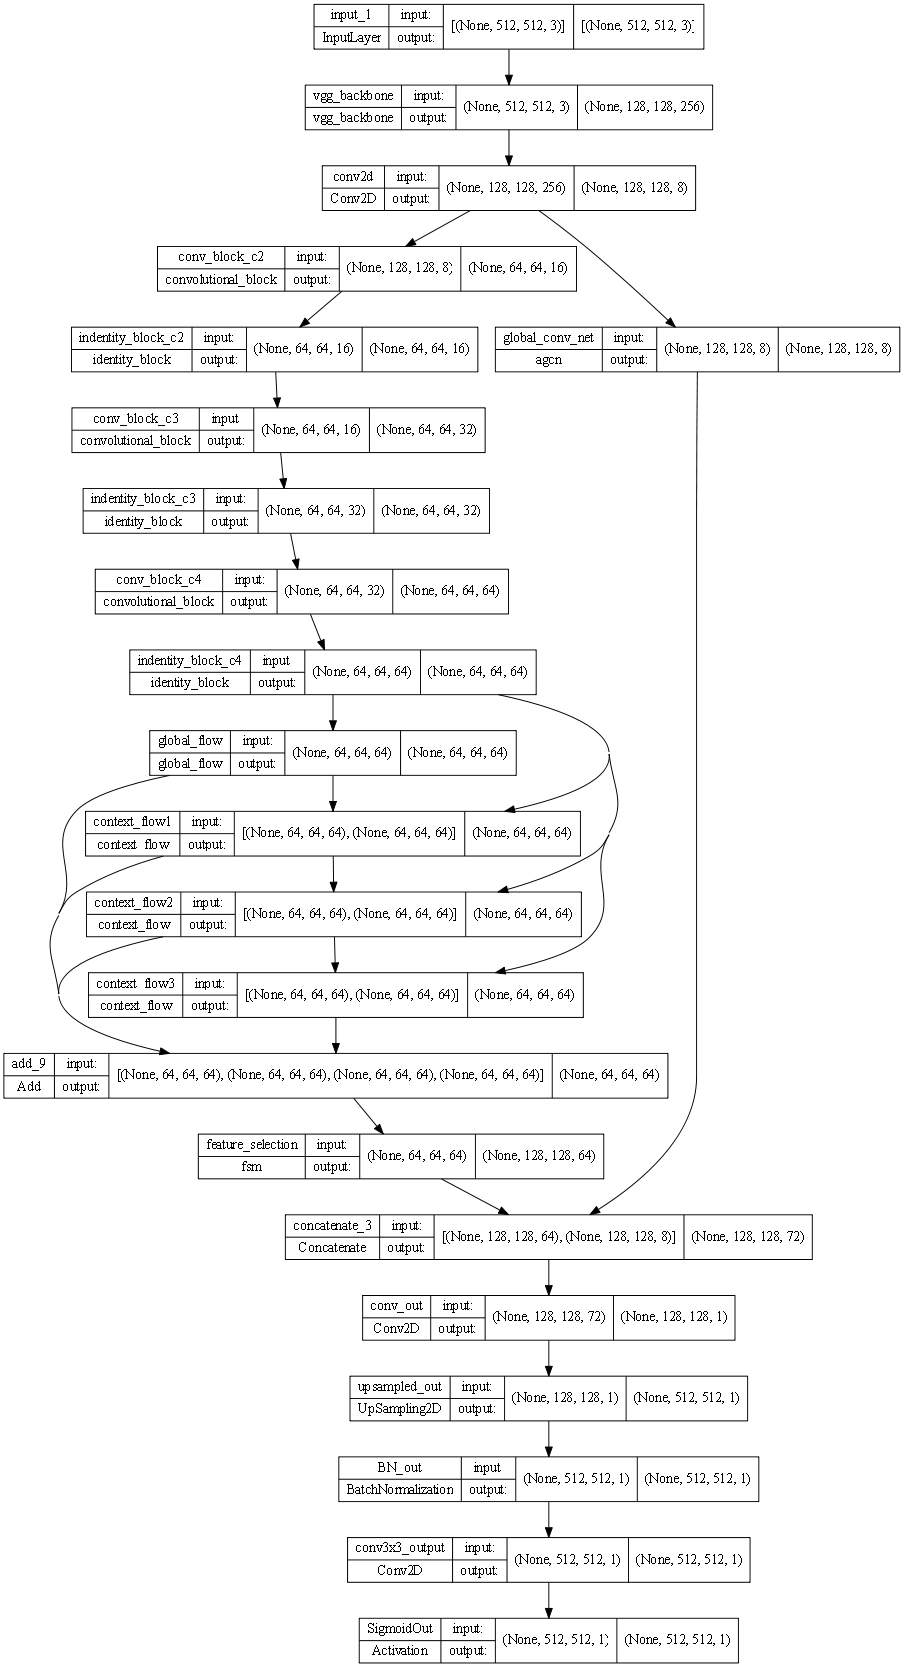

In [7]:
tf.keras.utils.plot_model(mm_model, show_shapes=True,to_file='custom_canet_model.png',dpi=70,show_layer_names=True,rankdir='TB')

In [8]:
train_annotations = COCO('livecell_coco_train.json')
valid_annotations = COCO("livecell_coco_val.json")

cat_ids = train_annotations.getCatIds(supNms=["cell"])

train_img_ids = []
for cat in cat_ids:
    train_img_ids.extend(train_annotations.getImgIds(catIds=cat))
    
train_img_ids = list(set(train_img_ids))
print(f"Number of training images: {len(train_img_ids)}")

valid_img_ids = []
for cat in cat_ids:
    valid_img_ids.extend(valid_annotations.getImgIds(catIds=cat))
    
valid_img_ids = list(set(valid_img_ids))
print(f"Number of validation images: {len(valid_img_ids)}")

loading annotations into memory...
Done (t=21.05s)
creating index...
index created!
loading annotations into memory...
Done (t=3.84s)
creating index...
index created!
Number of training images: 3253
Number of validation images: 570


In [9]:
train_data = ImageData4(train_annotations, train_img_ids, cat_ids, 'livecell_train_val_images',augmentation=get_training_augmentation())
valid_data = ImageData4(valid_annotations, valid_img_ids, cat_ids, 'livecell_train_val_images',augmentation=get_validation_augmentation())

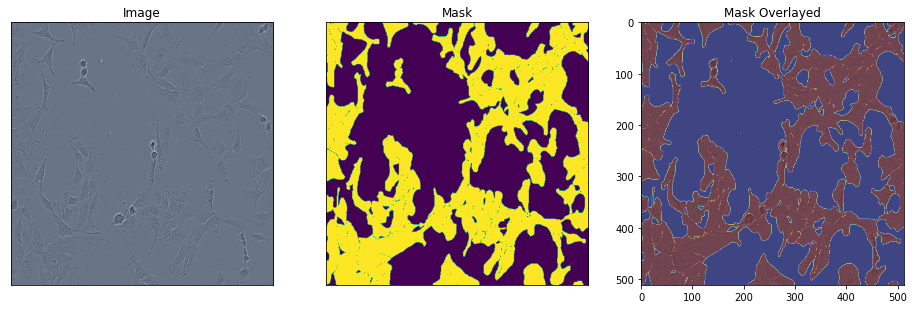

In [10]:
image, mask = train_data[199]
visualize(
    image=image, 
    mask=mask.squeeze())

In [11]:
BATCH_SIZE = 2
train_dataloader = Dataloder(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_data, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 1)

In [13]:
steps_per_epoch = np.ceil(len(train_dataloader)/BATCH_SIZE)
validation_steps = np.ceil(len(valid_dataloader)/BATCH_SIZE)

print(steps_per_epoch,validation_steps)

optim = tf.keras.optimizers.Adam(0.002)

n_classes = 4
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

mm_model.compile(optim, total_loss, metrics)

813.0 143.0


In [14]:
history = mm_model.fit(train_dataloader, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=10,
                        validation_data=valid_dataloader,
                        validation_steps = validation_steps)

Epoch 1/10
813/813 [==============================] - 759s 920ms/step - loss: 0.4098 - iou_score: 0.4894 - f1-score: 0.6397 - val_loss: 0.2561 - val_iou_score: 0.6335 - val_f1-score: 0.7720
Epoch 2/10
813/813 [==============================] - 706s 869ms/step - loss: 0.3440 - iou_score: 0.5609 - f1-score: 0.7046 - val_loss: 0.2474 - val_iou_score: 0.6195 - val_f1-score: 0.7601
Epoch 3/10
813/813 [==============================] - 723s 887ms/step - loss: 0.3382 - iou_score: 0.5651 - f1-score: 0.7089 - val_loss: 0.2242 - val_iou_score: 0.6626 - val_f1-score: 0.7932
Epoch 4/10
813/813 [==============================] - 827s 1s/step - loss: 0.3024 - iou_score: 0.6116 - f1-score: 0.7496 - val_loss: 0.1994 - val_iou_score: 0.7065 - val_f1-score: 0.8248
Epoch 5/10
813/813 [==============================] - 825s 1s/step - loss: 0.2983 - iou_score: 0.6185 - f1-score: 0.7553 - val_loss: 0.1894 - val_iou_score: 0.7229 - val_f1-score: 0.8360
Epoch 6/10
813/813 [==============================] - 86

In [15]:
mm_model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


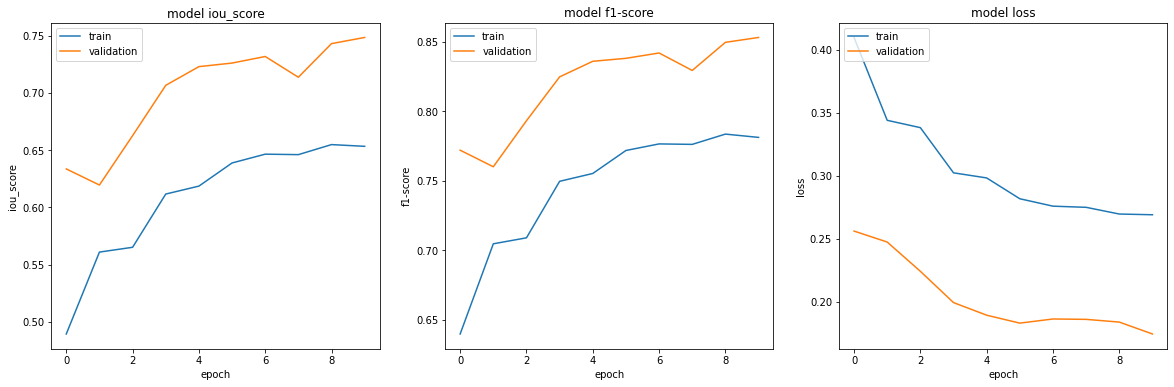

In [22]:
plt.figure(figsize=(20,6))
# IOU
plt.subplot(1,3,1)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('model iou_score')
plt.ylabel('iou_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# F1 score
plt.subplot(1,3,2)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('model f1-score')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# "Loss"
plt.subplot(1,3,3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()